In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:

DATASET_PATH = '../data/water_potability.csv'
raw_df = pd.read_csv(DATASET_PATH)

In [3]:
# Asumptions
NUMERICAL_FEATURES = ['ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate', 'Conductivity', 'Organic_carbon', 'Trihalomethanes',  'Turbidity']
NUMERICAL_CONTINOUS = NUMERICAL_FEATURES
CATEGORY_FEATURES = ['Potability']

TARGET = "Potability"

In [4]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2785 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Solids           3276 non-null   float64
 3   Chloramines      3276 non-null   float64
 4   Sulfate          2495 non-null   float64
 5   Conductivity     3276 non-null   float64
 6   Organic_carbon   3276 non-null   float64
 7   Trihalomethanes  3114 non-null   float64
 8   Turbidity        3276 non-null   float64
 9   Potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB


In [5]:
# Chequear si alguna fila en cualquier columna tiene NaN

# Identificar filas con al menos un valor NaN
nan_rows_mask = raw_df.isna().any(axis=1)
# Esto da una Serie booleana, donde 'True' indica una fila con al menos un NaN.
nan_rows = raw_df[nan_rows_mask]

In [6]:
nan_rows.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
8,NaN,118.988579,14285.583854,7.804174,268.646941,389.375566,12.706049,53.928846,3.595017,0
11,7.974522,218.693300,18767.656682,8.110385,NaN,364.098230,14.525746,76.485911,4.011718,0


In [7]:
for column in raw_df.columns:
    na_count = sum(raw_df[column].isna())
    print(f"{column} NaNs: {na_count} - {round(((na_count * 100) / len(raw_df)), 1)}%")

ph NaNs: 491 - 15.0%
Hardness NaNs: 0 - 0.0%
Solids NaNs: 0 - 0.0%
Chloramines NaNs: 0 - 0.0%
Sulfate NaNs: 781 - 23.8%
Conductivity NaNs: 0 - 0.0%
Organic_carbon NaNs: 0 - 0.0%
Trihalomethanes NaNs: 162 - 4.9%
Turbidity NaNs: 0 - 0.0%
Potability NaNs: 0 - 0.0%


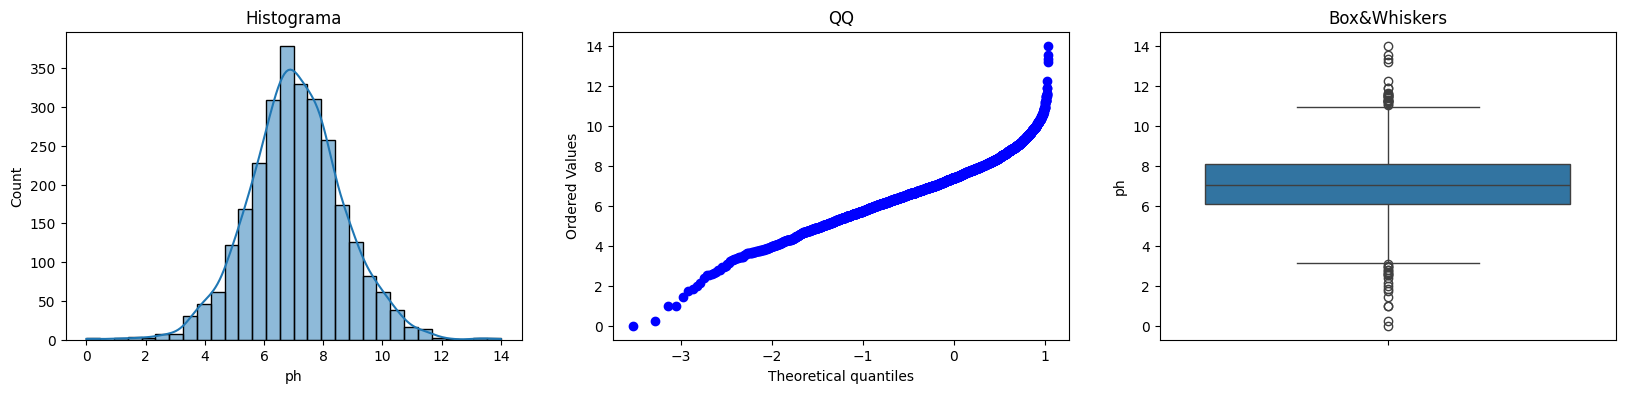

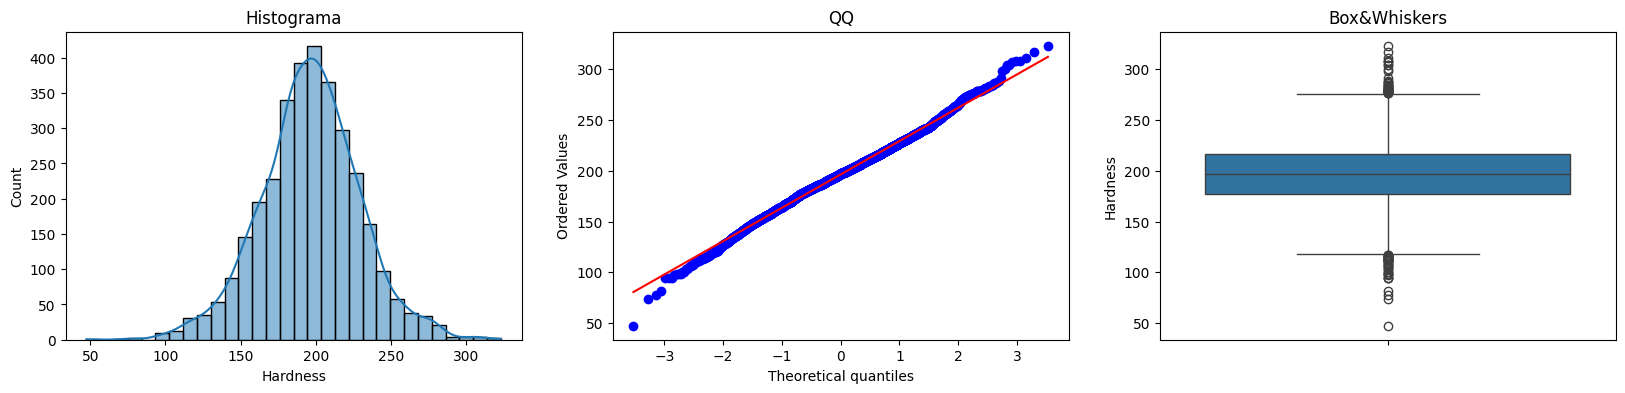

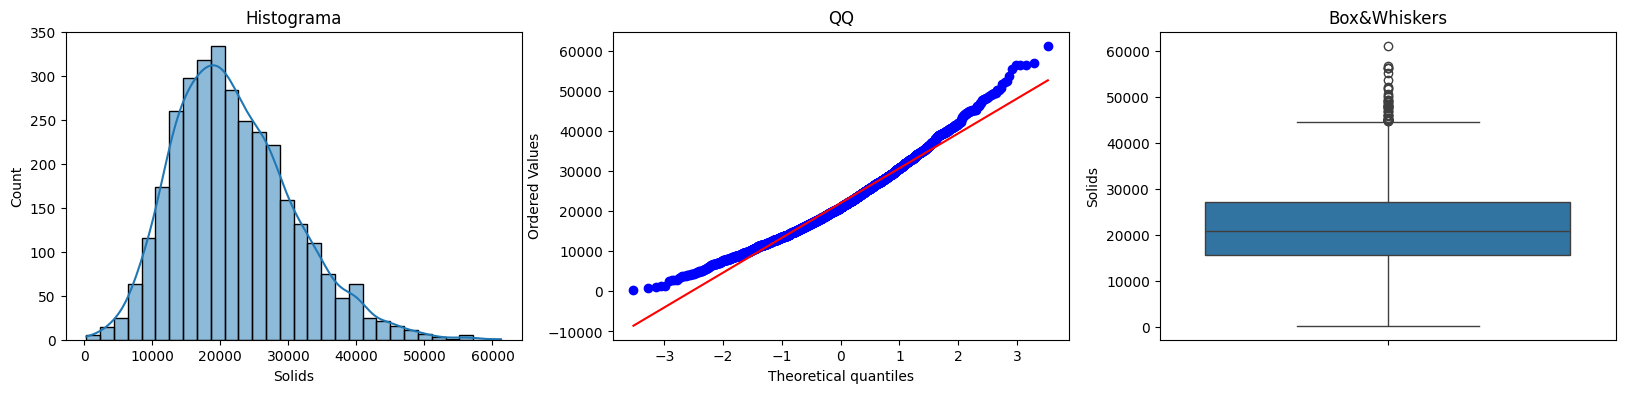

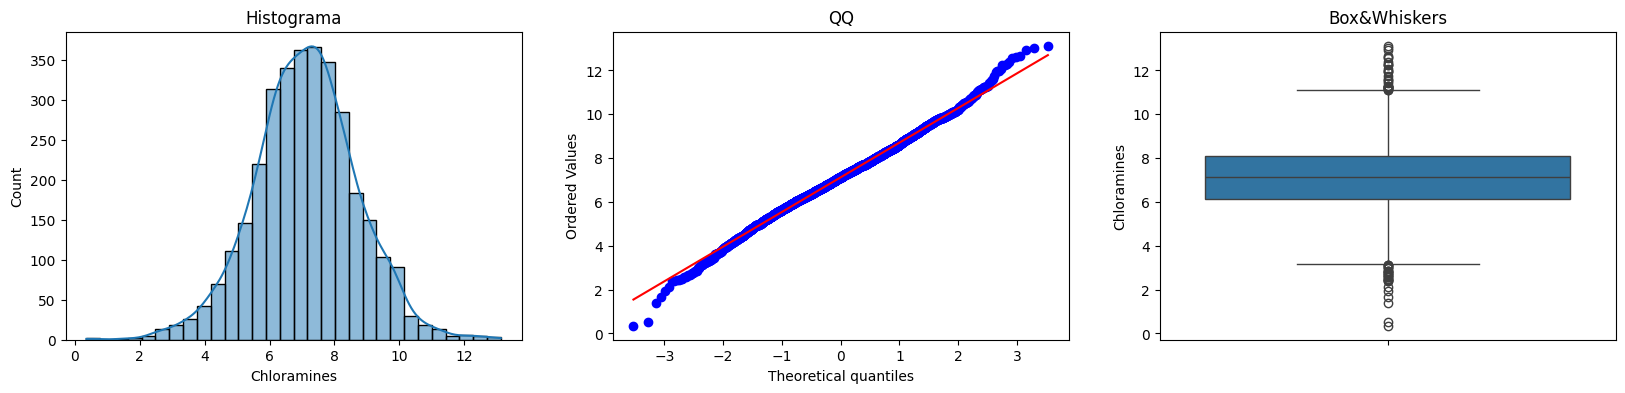

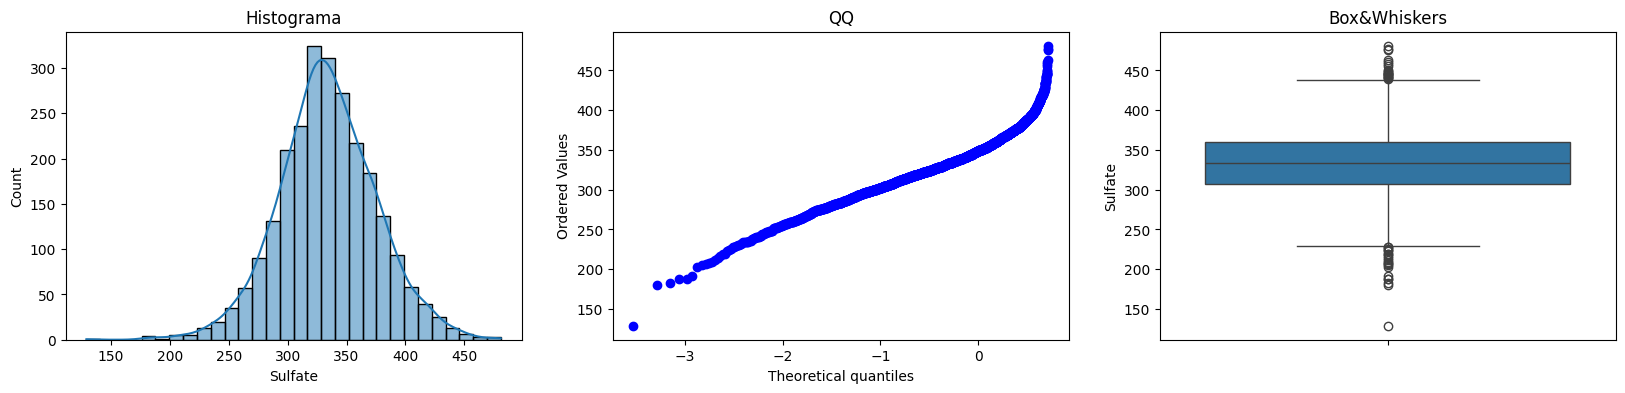

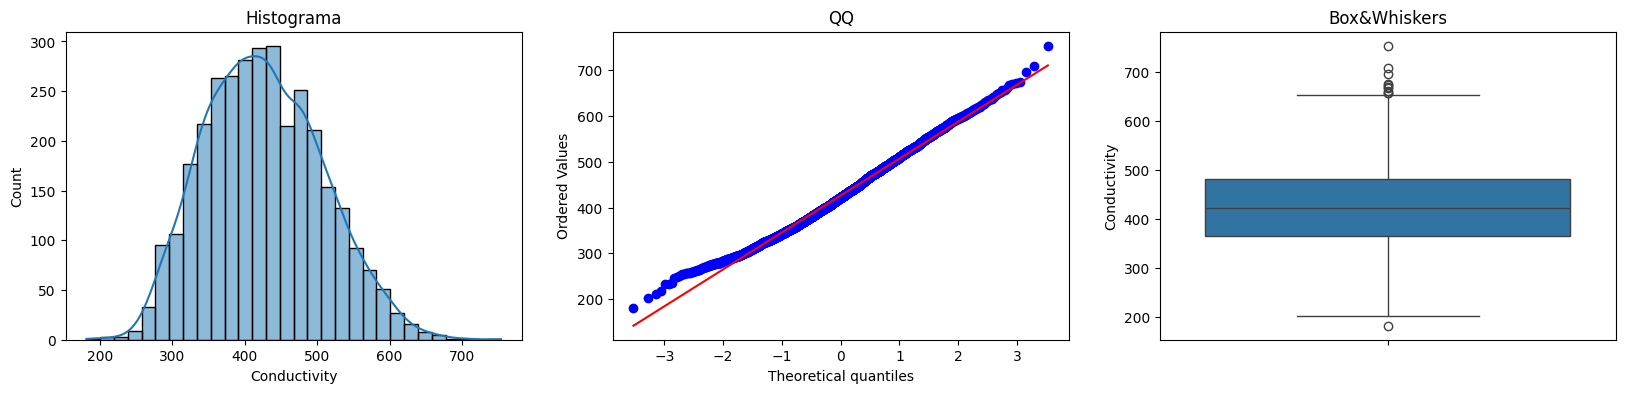

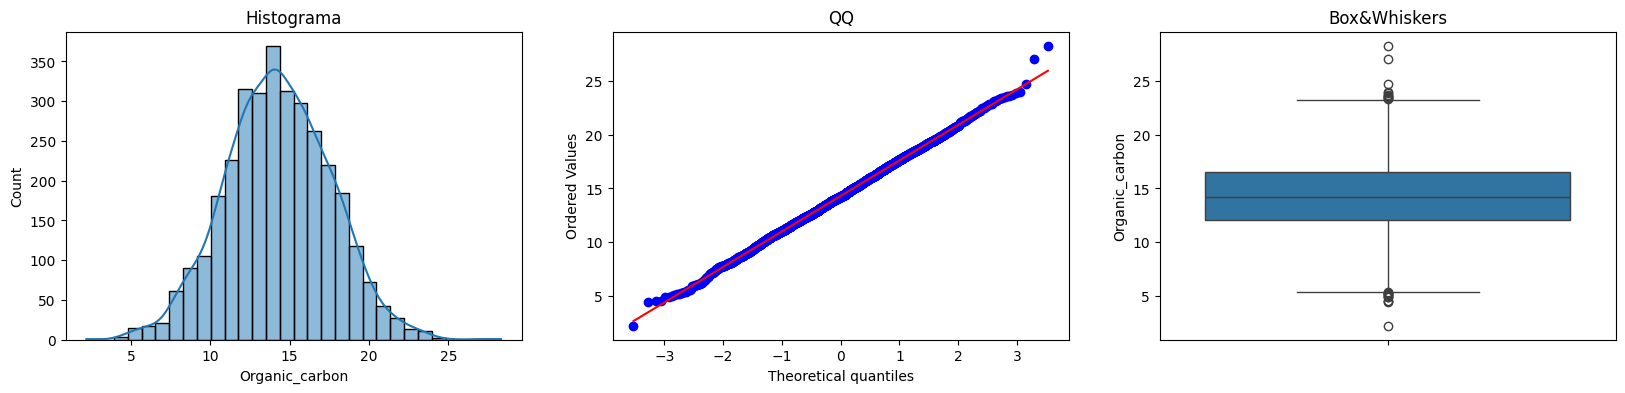

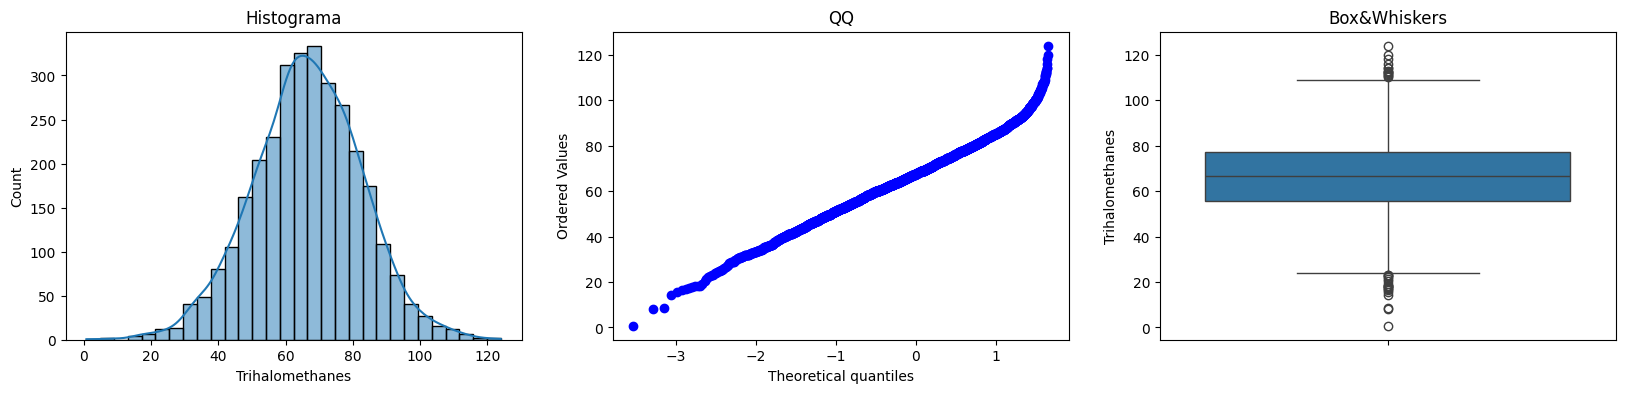

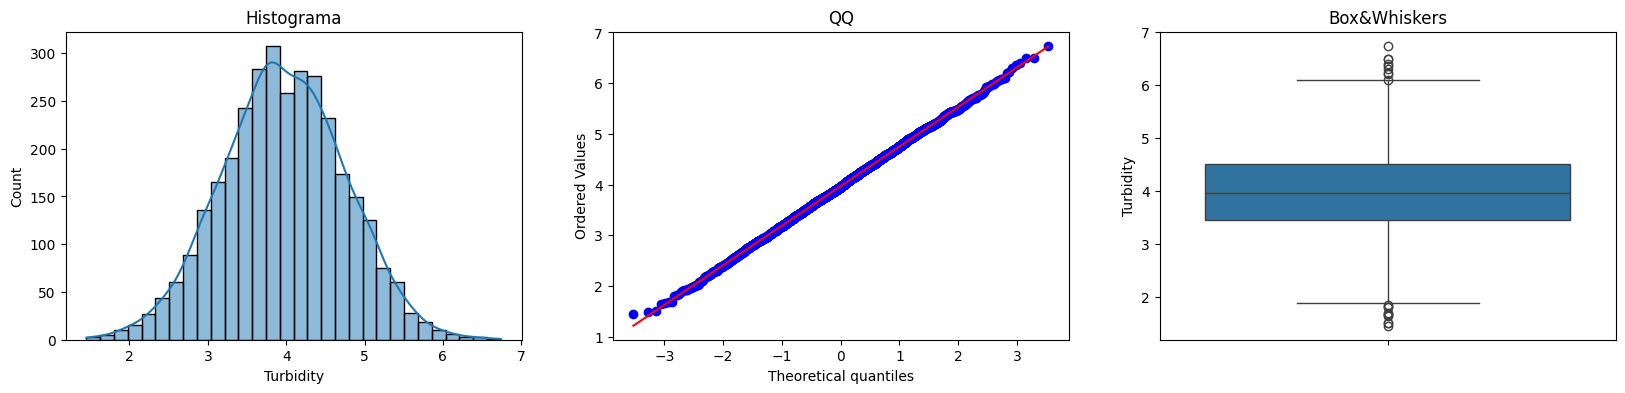

In [8]:
from utils import outlier_diagnostic_plots

for column in raw_df[NUMERICAL_CONTINOUS].columns:
    outlier_diagnostic_plots(raw_df, column)

Como tenemos valores faltantes en 3 columnas que representan un porcentaje significativo del total (mayor al 5%), vamos a ver los resultados de una imputacion Univariada y Multivariada:

### Imputacion Univariada - Imputación por muestreo aleatorio

Como las variables tienen distribuciones muy cercanas a una distribución normal, nuestra idea es tratar de imputar los datos faltantes manteniendo la misma distribución, sin introducir grandes distrociones.

In [9]:
raw_df_2 = raw_df.copy()

In [10]:
# Obtenemos las columnas que contienen al menos un NaN
nan_columns = raw_df_2.columns[raw_df_2.isna().any()].tolist()

for column in nan_columns:
    # Obtenemos los valores no NaN de la columna
    no_nan_values = raw_df_2[column].dropna()
    # Imputamos los valores NaN con muestreo aleatorio de los valores no NaN
    raw_df_2[column] = raw_df_2[column].apply(
        lambda x: np.random.choice(no_nan_values) if np.isnan(x) else x
    )

In [11]:
raw_df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               3276 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Solids           3276 non-null   float64
 3   Chloramines      3276 non-null   float64
 4   Sulfate          3276 non-null   float64
 5   Conductivity     3276 non-null   float64
 6   Organic_carbon   3276 non-null   float64
 7   Trihalomethanes  3276 non-null   float64
 8   Turbidity        3276 non-null   float64
 9   Potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB


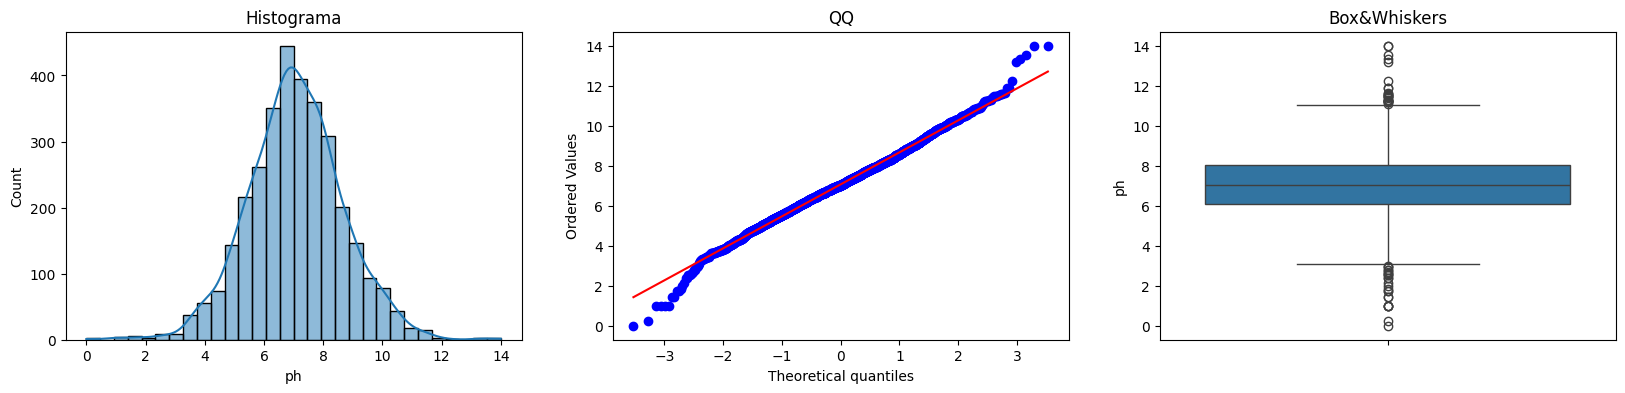

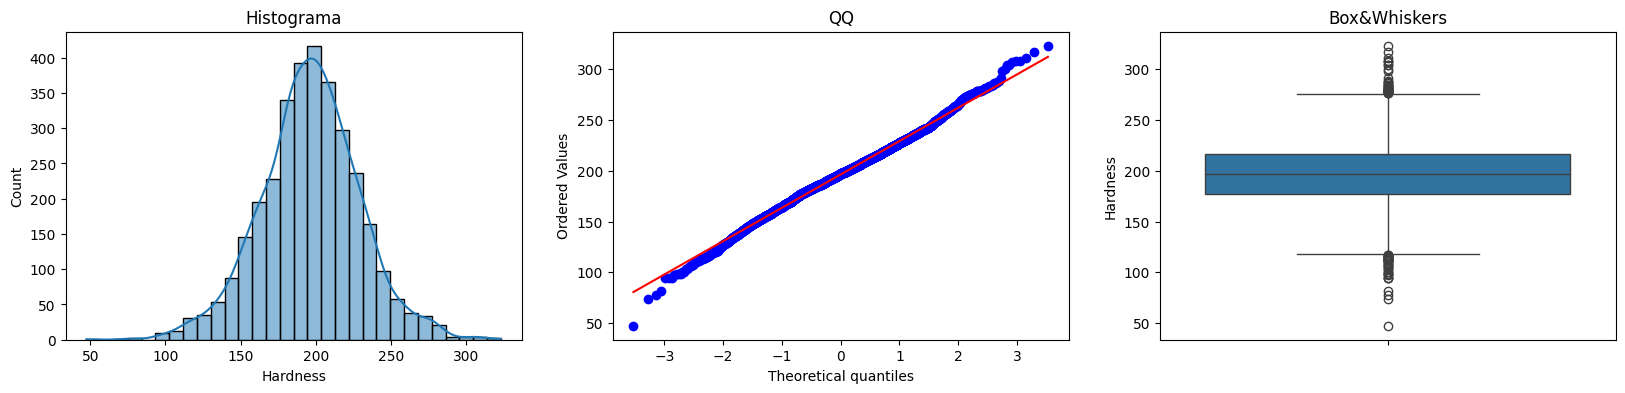

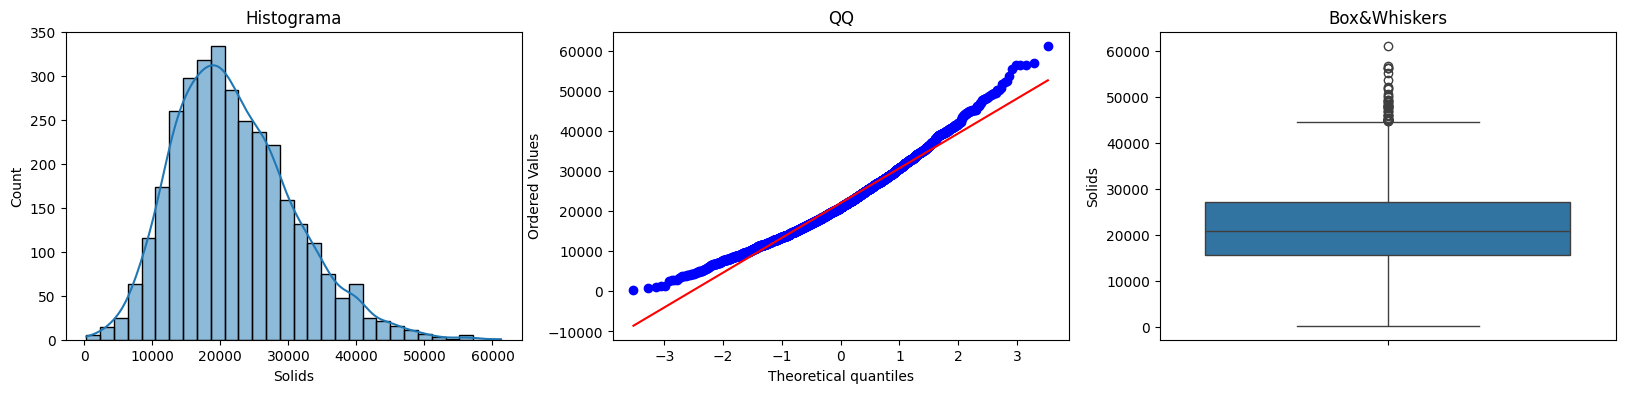

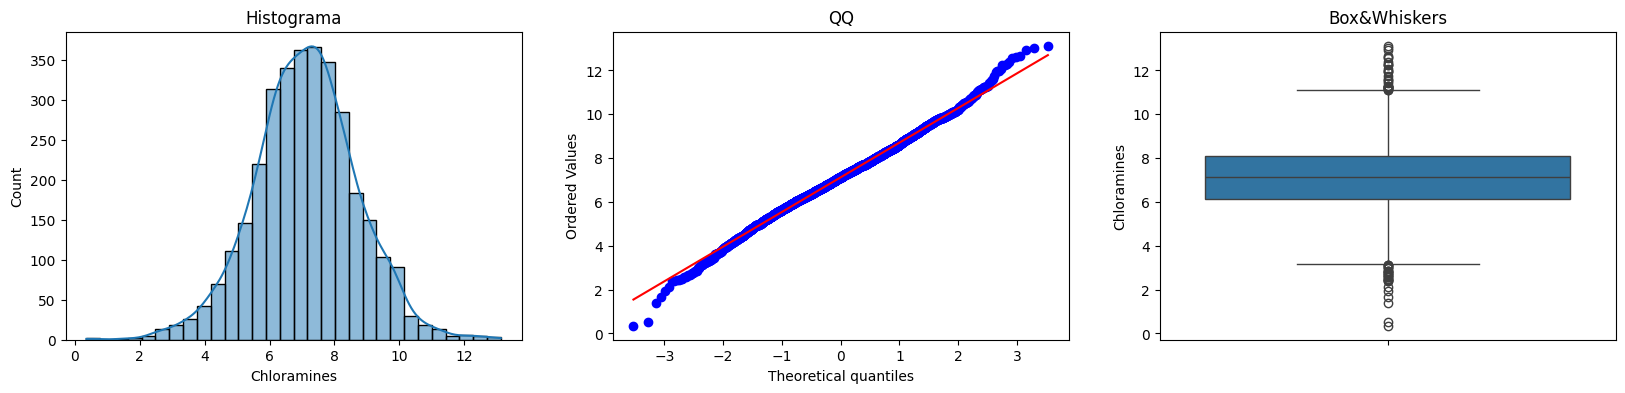

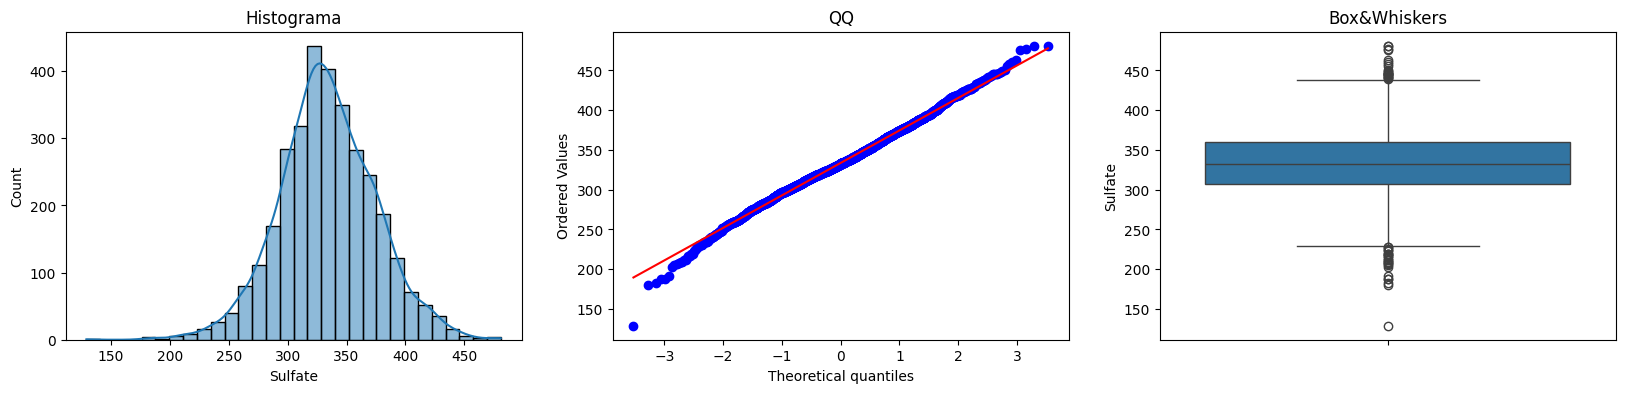

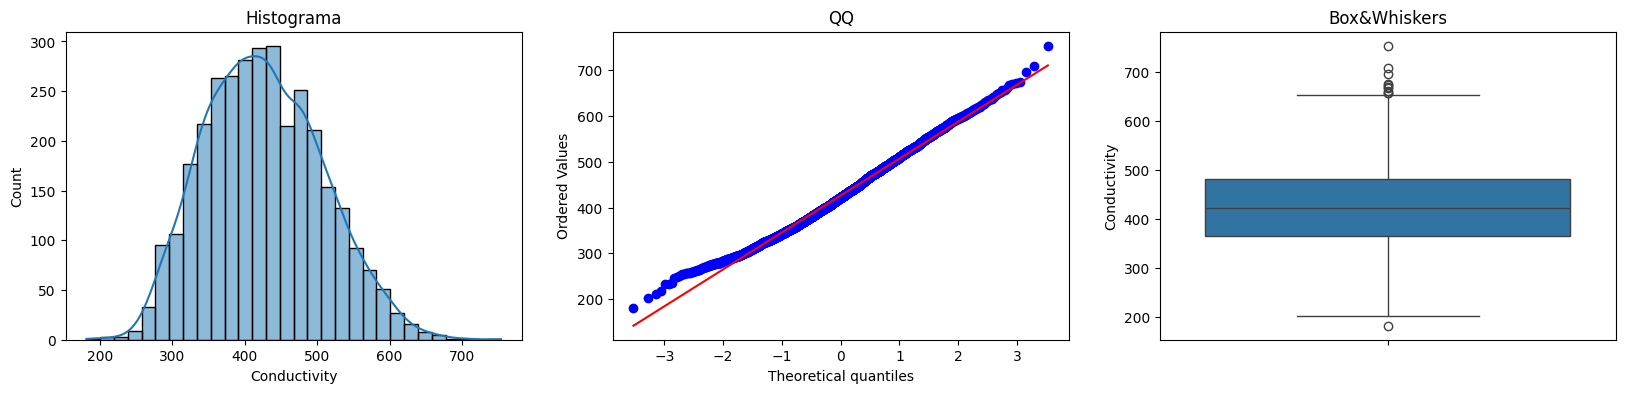

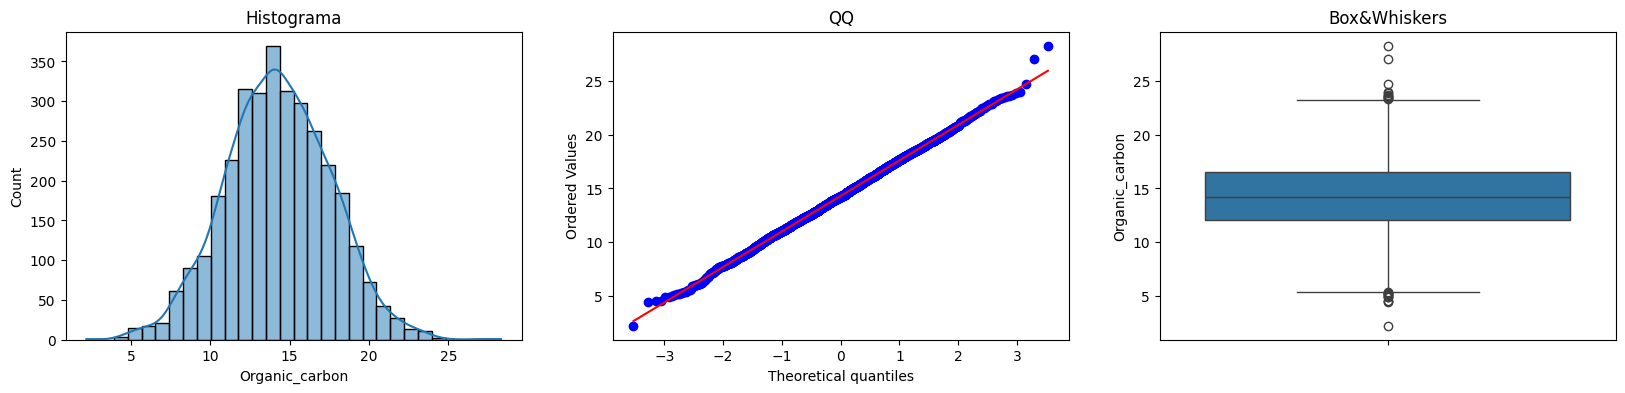

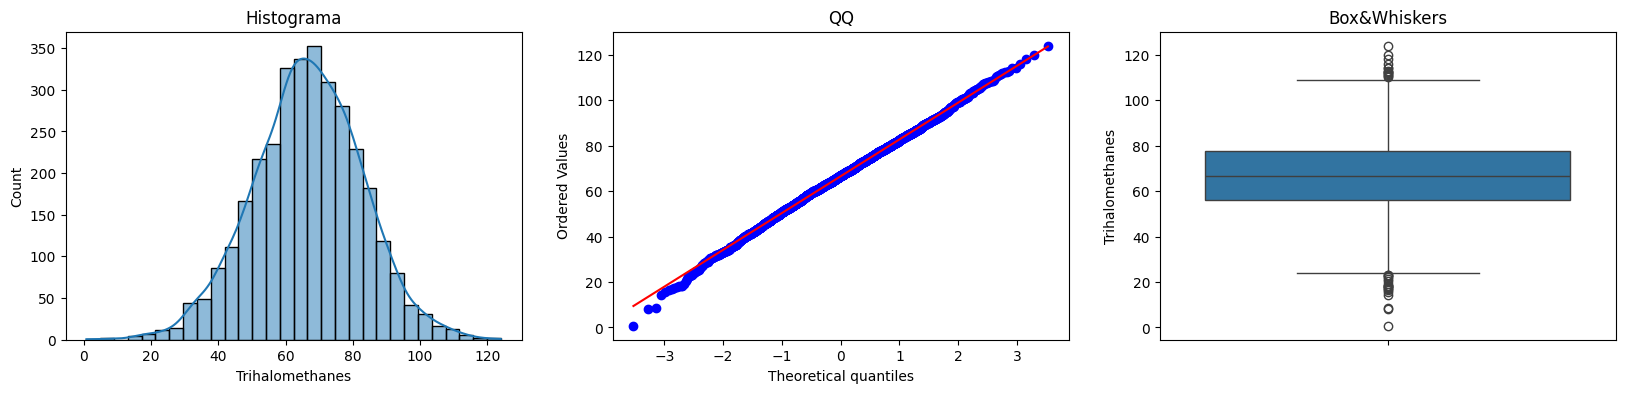

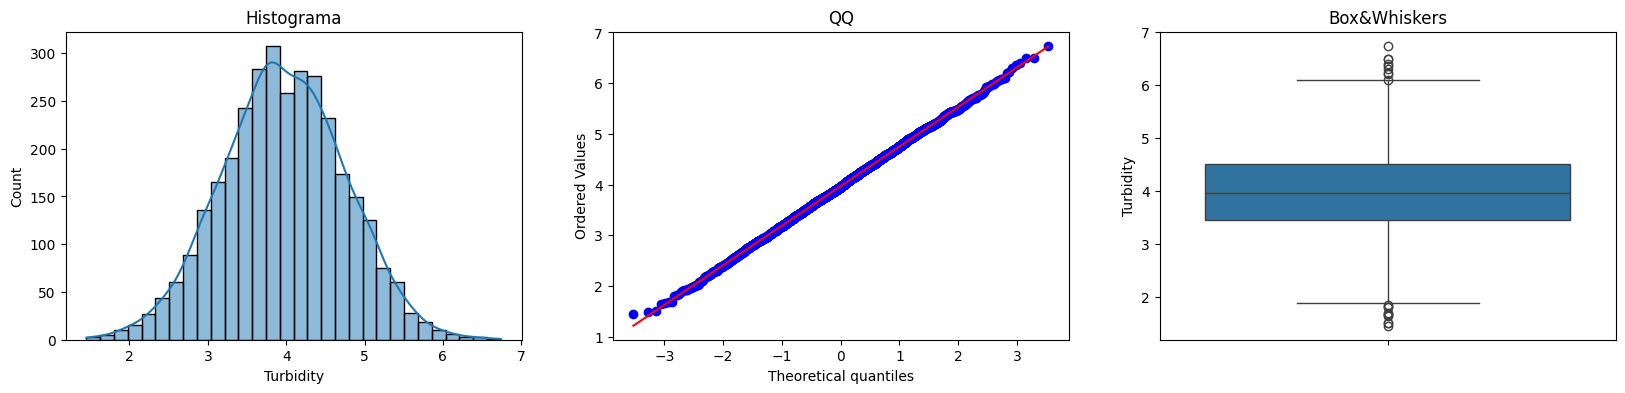

In [12]:
for column in raw_df_2[NUMERICAL_CONTINOUS].columns:
    outlier_diagnostic_plots(raw_df_2, column)

### Multiple Imputation by Chained Equations (MICE)

- Calcula valores faltantes para cada columna como una regresión lineal de las restantes (si bien también se pueden usar otros modelos). Como utiliza el resto de las columnas, es un método **multivariado**.
- Es iterativo porque repite este proceso hasta que la diferencia entre las dos últimas iteraciones sea cercana a cero.

In [13]:
raw_df_3 = raw_df.copy()

In [14]:
raw_df_3[NUMERICAL_FEATURES]

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075
...,...,...,...,...,...,...,...,...,...
3271,4.668102,193.681735,47580.991603,7.166639,359.948574,526.424171,13.894419,66.687695,4.435821
3272,7.808856,193.553212,17329.802160,8.061362,NaN,392.449580,19.903225,NaN,2.798243
3273,9.419510,175.762646,33155.578218,7.350233,NaN,432.044783,11.039070,69.845400,3.298875
3274,5.126763,230.603758,11983.869376,6.303357,NaN,402.883113,11.168946,77.488213,4.708658


Búsqueda de mejores parámetros por Grid Search.

In [15]:
X = raw_df_3[NUMERICAL_FEATURES].values
y = raw_df_3[TARGET].values

In [16]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.experimental import enable_iterative_imputer
from sklearn.model_selection import GridSearchCV, cross_val_score, RepeatedStratifiedKFold
from sklearn.impute import IterativeImputer


param_grid = {
    "imputer__n_nearest_features": [None] + list(range(1, len(NUMERICAL_FEATURES) + 1))
}

pipeline = Pipeline(steps=[
    ('imputer', IterativeImputer()), 
    ('lr', LogisticRegression(max_iter=1000))
])
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=42)
grid_search = GridSearchCV(estimator=pipeline,param_grid=param_grid,cv=cv, scoring="f1", n_jobs=-1)

grid_search.fit(X, y)

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=5, n_splits=5, random_state=42),
             estimator=Pipeline(steps=[('imputer', IterativeImputer()),
                                       ('lr',
                                        LogisticRegression(max_iter=1000))]),
             n_jobs=-1,
             param_grid={'imputer__n_nearest_features': [None, 1, 2, 3, 4, 5, 6,
                                                         7, 8, 9]},
             scoring='f1')

In [17]:
# Mejores parámetros y puntuación
grid_search.best_params_


{'imputer__n_nearest_features': 6}

In [18]:
grid_search.best_score_

0.000625

In [19]:
# El mejor estimador
grid_search.best_estimator_

Pipeline(steps=[('imputer', IterativeImputer(n_nearest_features=6)),
                ('lr', LogisticRegression(max_iter=1000))])

In [20]:
best_mice_imputer = grid_search.best_estimator_['imputer']

In [21]:
X_imputed = best_mice_imputer.transform(X)

In [22]:
X_imputed.shape

(3276, 9)

In [23]:
y.shape

(3276,)

In [24]:
y = y.reshape(-1, 1)

In [25]:
y.shape

(3276, 1)

In [26]:
df_final = pd.DataFrame(data=np.concatenate((X_imputed, y), axis=1), columns=raw_df_3.columns)

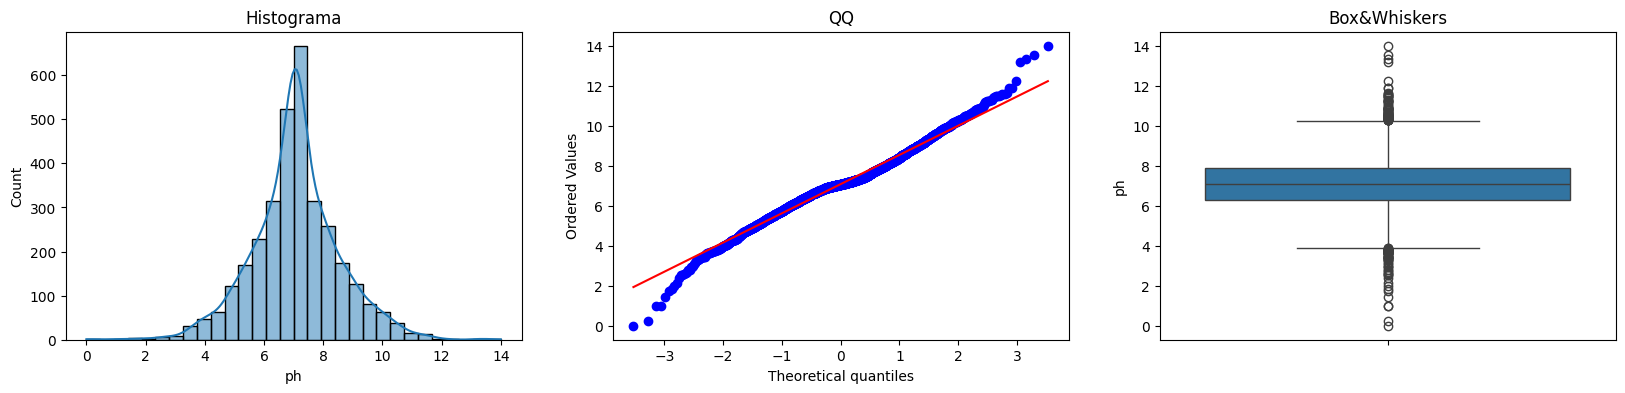

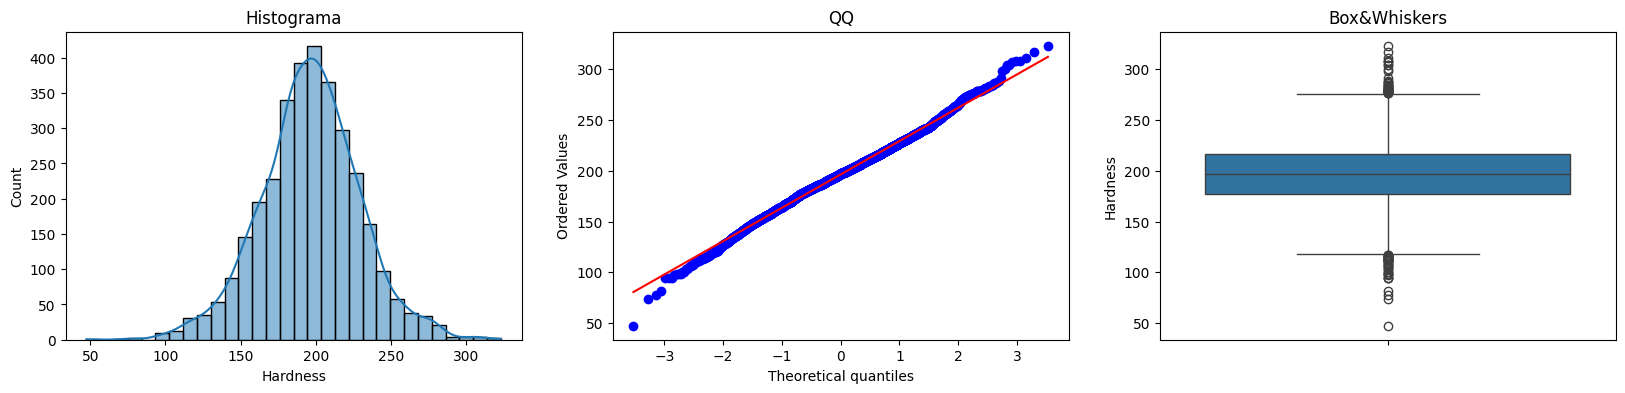

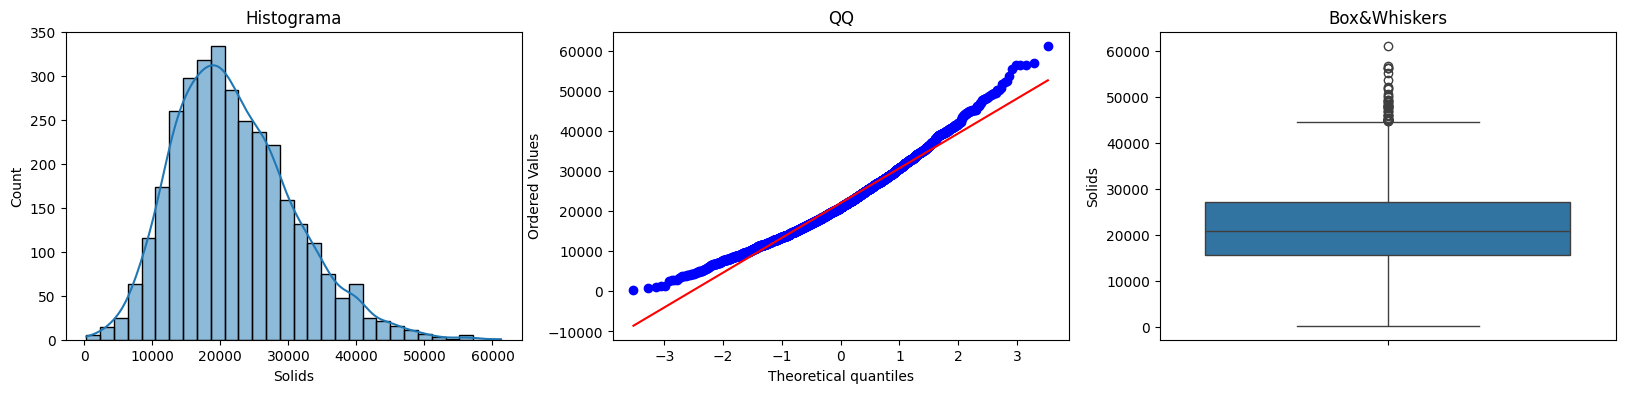

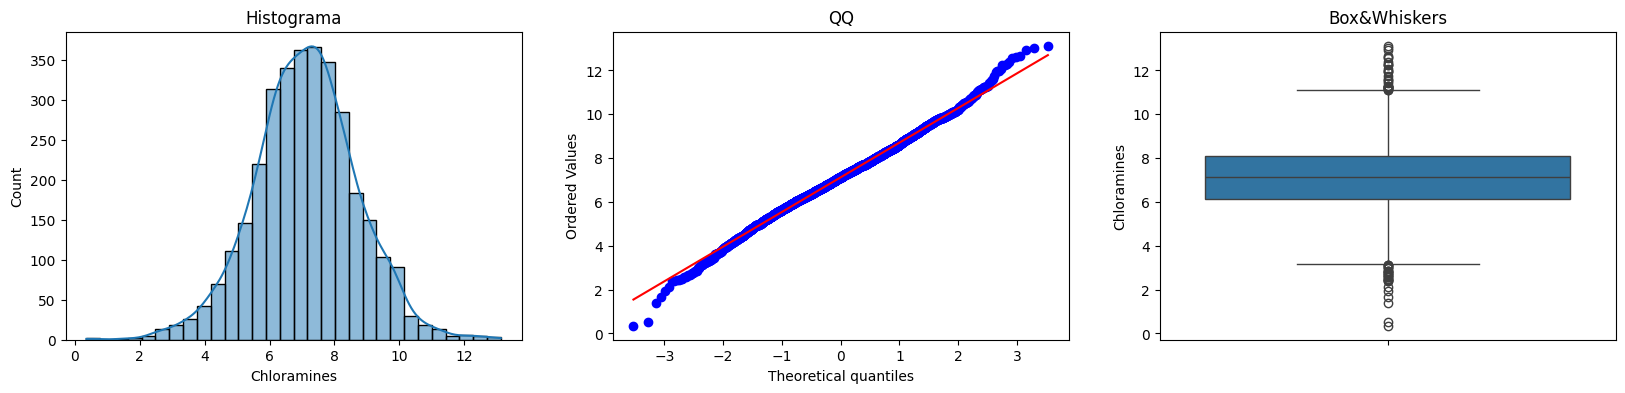

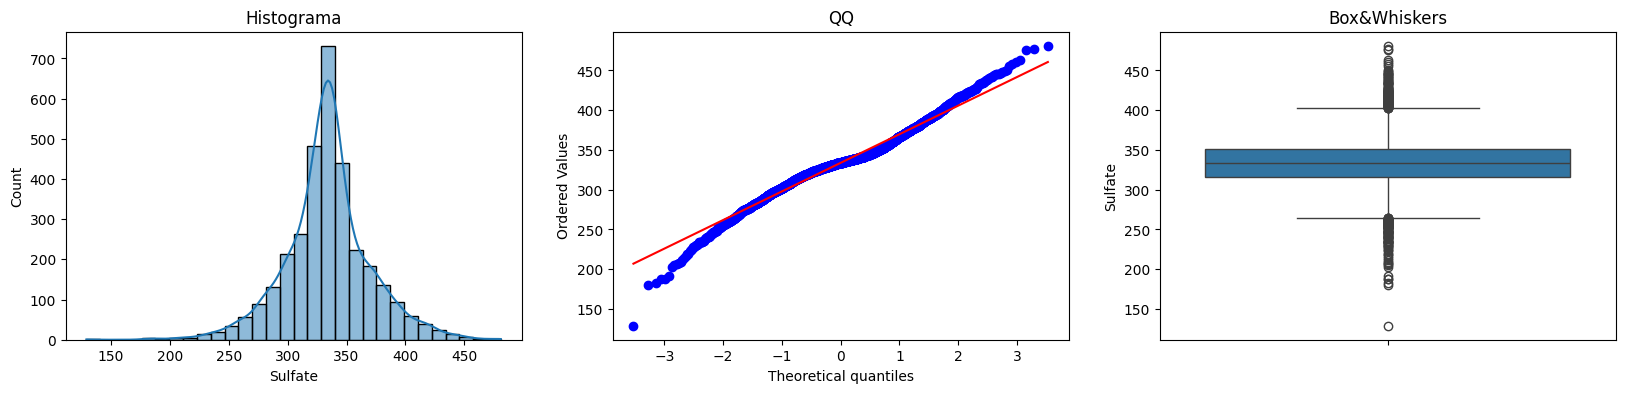

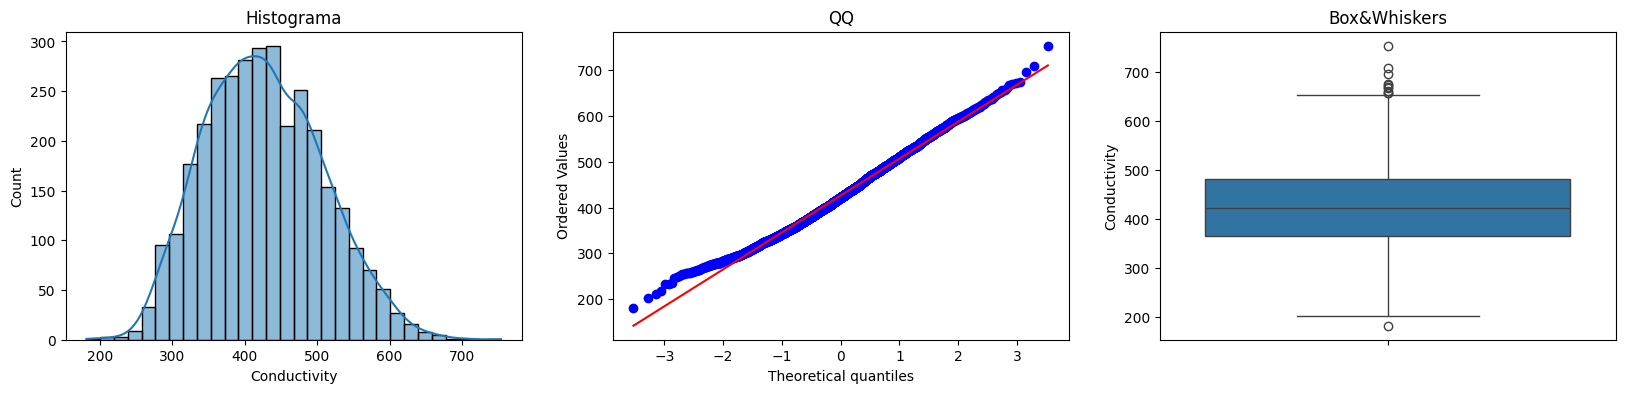

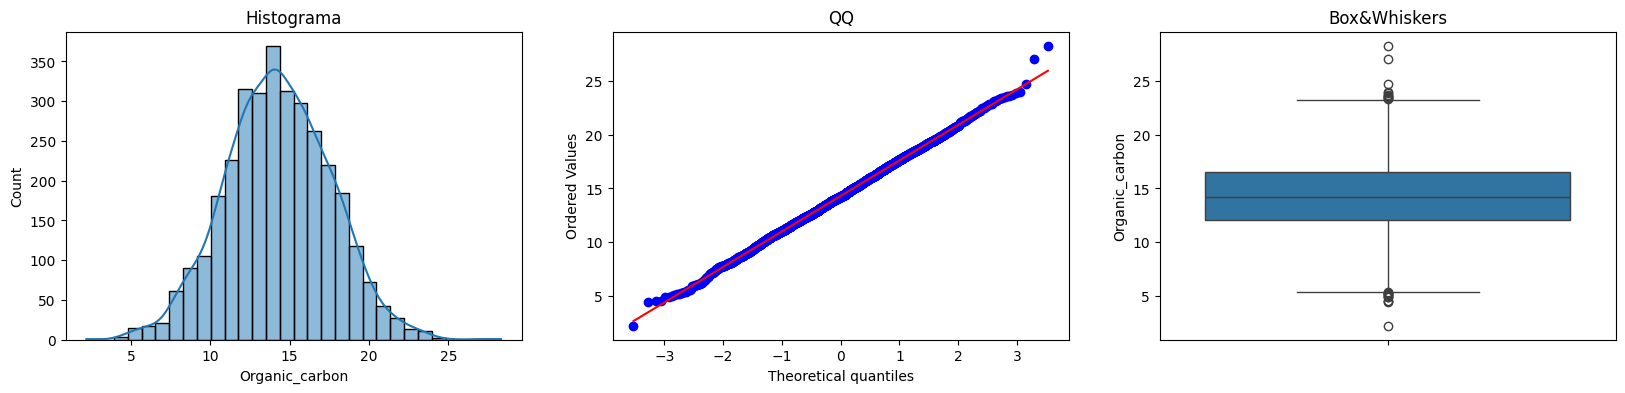

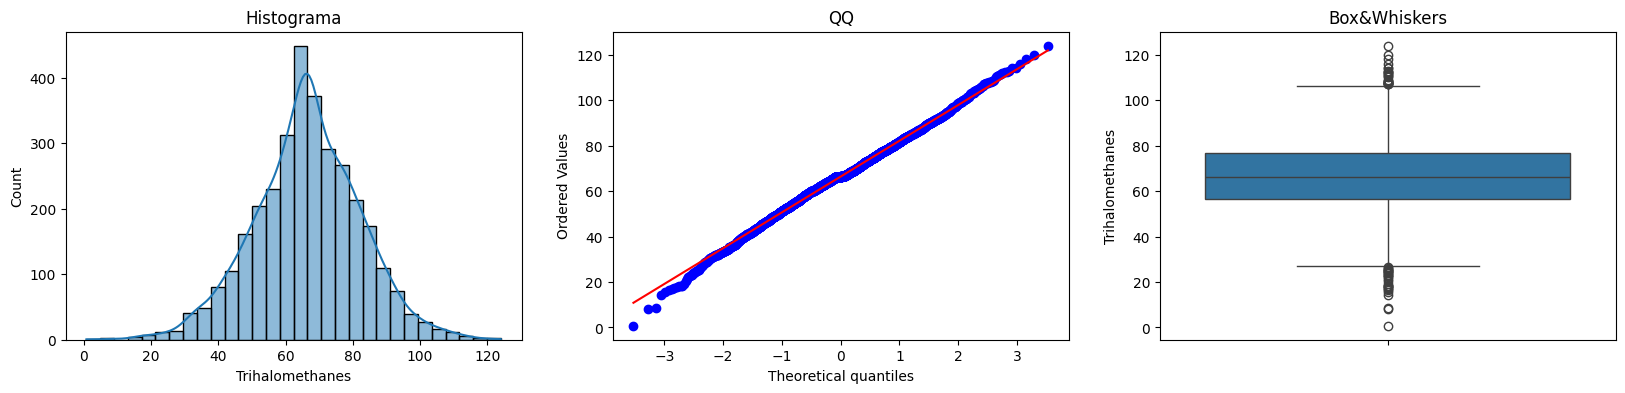

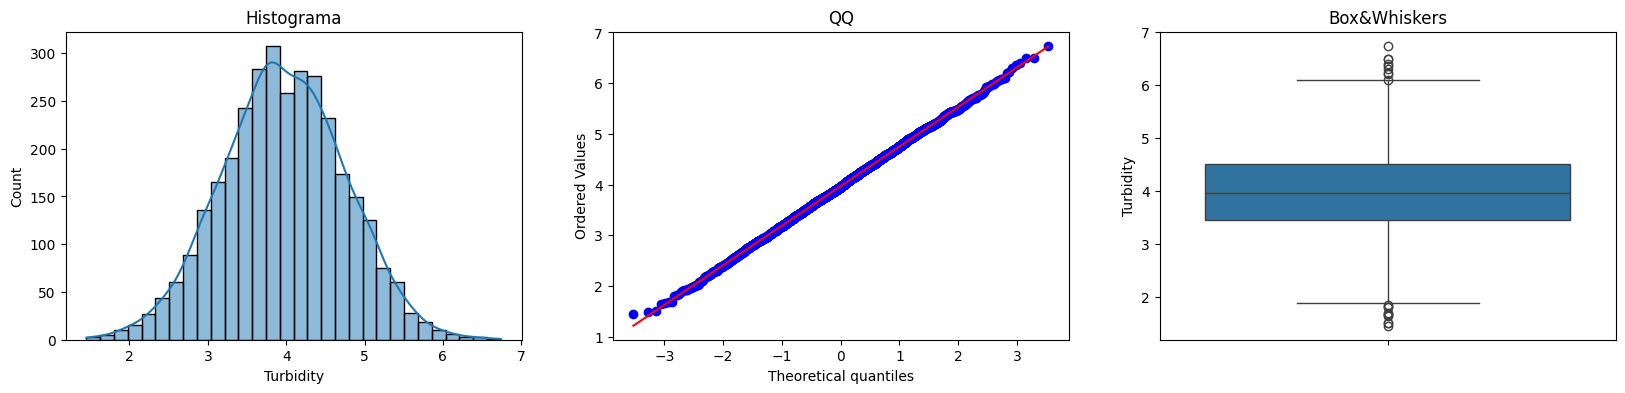

In [27]:
for column in df_final[NUMERICAL_CONTINOUS].columns:
    outlier_diagnostic_plots(df_final, column)

In [34]:
import numpy as np
from matplotlib import offsetbox
from sklearn.preprocessing import MinMaxScaler


def plot_embedding(X, title):
    _, ax = plt.subplots()
    X = MinMaxScaler().fit_transform(X)

    for digit in [1, 0]:
        ax.scatter(
            *X[y == digit].T,
            marker=f"${digit}$",
            s=60,
            color=plt.cm.Dark2(digit),
            alpha=0.425,
            zorder=2,
        )
    # shown_images = np.array([[1.0, 1.0]])  # just something big
    # for i in range(X.shape[0]):
    #     # plot every digit on the embedding
    #     # show an annotation box for a group of digits
    #     dist = np.sum((X[i] - shown_images) ** 2, 1)
    #     if np.min(dist) < 4e-3:
    #         # don't show points that are too close
    #         continue
    #     shown_images = np.concatenate([shown_images, [X[i]]], axis=0)
    #     imagebox = offsetbox.AnnotationBbox(
    #         offsetbox.OffsetImage(digits.images[i], cmap=plt.cm.gray_r), X[i]
    #     )
    #     imagebox.set(zorder=1)
    #     ax.add_artist(imagebox)

    ax.set_title(title)
    ax.axis("off")

In [40]:
import numpy as np
from matplotlib import offsetbox
from sklearn.preprocessing import MinMaxScaler


def plot_embedding(X, title):
    _, ax = plt.subplots()
    X = MinMaxScaler().fit_transform(X)

    for digit in [1, 0]:
        ax.scatter(
            *X[y.reshape(-1, ) == digit].T,
            marker=f"${digit}$",
            s=60,
            color=plt.cm.Dark2(digit),
            alpha=0.425,
            zorder=2,
        )

    ax.set_title(title)
    ax.axis("off")

In [42]:
from sklearn.decomposition import TruncatedSVD, PCA, FastICA
from sklearn.manifold import MDS, TSNE

embeddings = {
    "PCA embedding": PCA(
        n_components=2,
        random_state=0
    ),
    "t-SNE embedding": TSNE(
        n_components=2,
        init="pca",
        learning_rate="auto",
        n_iter=500,
        n_iter_without_progress=150,
        n_jobs=2,
        random_state=0,
    ),
}

In [44]:
from time import time

projections, timing = {}, {}
for name, transformer in embeddings.items():
    if name.startswith("Linear Discriminant Analysis"):
        data = X_imputed.copy()
        data.flat[:: X_imputed.shape[1] + 1] += 0.01  # Make X invertible
    else:
        data = X_imputed

    print(f"Computing {name}...")
    start_time = time()
    projections[name] = transformer.fit_transform(data, y)
    timing[name] = time() - start_time

Computing PCA embedding...
Computing t-SNE embedding...


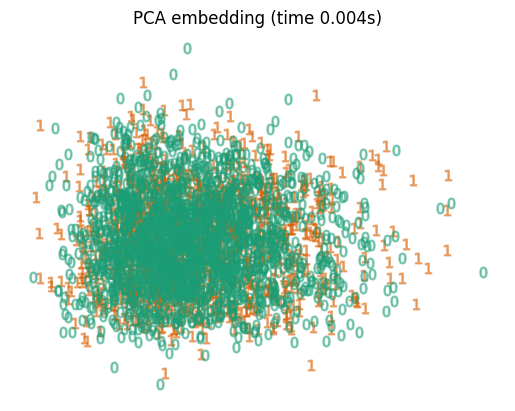

In [45]:
name = 'PCA embedding'
title = f"{name} (time {timing[name]:.3f}s)"
plot_embedding(projections[name], title)

plt.show()

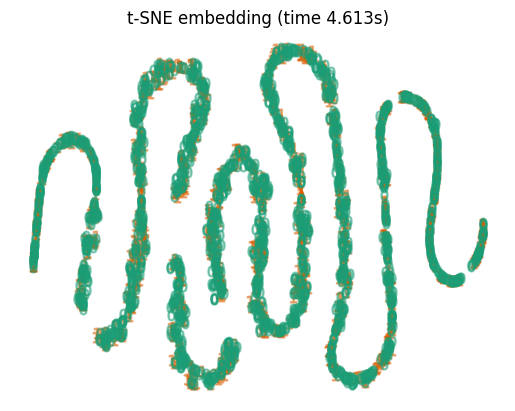

In [46]:
name = 't-SNE embedding'
title = f"{name} (time {timing[name]:.3f}s)"
plot_embedding(projections[name], title)

plt.show()